
# Project AI


In [4]:

# === Imports ===
import os, sys, numpy as np, pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
np.random.seed(42)
tf.random.set_seed(42)
print("Imports OK")


Imports OK


In [5]:
# Load the dataset
train_df = pd.read_csv("/Users/poraya/Documents/AI-project/train.csv")
test_df = pd.read_csv("/Users/poraya/Documents/AI-project/test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Preview dataset
train_df.head()

Train shape: (8693, 14)
Test shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [7]:
# === Basic cleaning & target (robust) ===
df = raw.copy()

# Target: Transported (boolean) -> int (drop NaNs)
df = df[df['Transported'].notna()].copy()
df['Transported'] = df['Transported'].astype(int)

# Drop clearly non-feature columns
drop_cols = ['PassengerId', 'Name', 'Cabin']
for ccol in drop_cols:
    if ccol in df.columns:
        df = df.drop(columns=ccol)

# Define columns
categorical = ['HomePlanet','CryoSleep','Destination','VIP']
numeric = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

categorical = [c for c in categorical if c in df.columns]
numeric = [c for c in numeric if c in df.columns]

# Numeric: coerce to float, fill NaN with 0
for cnum in numeric:
    df[cnum] = pd.to_numeric(df[cnum], errors='coerce')
df[numeric] = df[numeric].fillna(0.0)

# Categorical: make all values *strings* (no bool/str mixing)
for ccat in categorical:
    # First, handle booleans explicitly if present
    if df[ccat].dropna().isin([True, False]).all():
        df[ccat] = df[ccat].map({True: 'True', False: 'False'})
    # Fill missing with a sentinel and cast to pandas StringDtype
    df[ccat] = df[ccat].astype('string')
    df[ccat] = df[ccat].fillna('Unknown')

# Final X/y
y = df['Transported'].values.astype(int)
X = df.drop(columns=['Transported'])

print("X dtypes summary:")
print(X.dtypes)
print("X shape:", X.shape, "y shape:", y.shape)

# Safety checks to avoid OneHotEncoder mixed types
for ccat in categorical:
    assert X[ccat].dtype.name in ['string', 'object'], f"{ccat} must be string-like"
for cnum in numeric:
    assert pd.api.types.is_numeric_dtype(X[cnum]), f"{cnum} must be numeric"


NameError: name 'raw' is not defined

In [4]:

# === Preview: cleaned features as a table ===
import pandas as pd
from IPython.display import display

# Combine X and y for a quick glance
preview_df = X.copy()
preview_df.insert(0, 'Transported', y)

# Show a compact table with all columns visible
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
print("Cleaned table preview (first 15 rows):")
display(preview_df.head(15))

# Optional: quick info and missing check
print("\nDtypes summary:")
print(preview_df.dtypes)

print("\nMissing values per column:")
print(preview_df.isna().sum())


Cleaned table preview (first 15 rows):


,Transported,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0
1,1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0
2,0,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0
3,0,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0
4,1,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0
5,1,Earth,False,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0
6,1,Earth,False,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0
7,1,Earth,True,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,0.0
8,1,Earth,False,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0
9,1,Europa,True,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0



Dtypes summary:
Transported              int64
HomePlanet      string[python]
CryoSleep       string[python]
Destination     string[python]
Age                    float64
VIP             string[python]
RoomService            float64
FoodCourt              float64
ShoppingMall           float64
Spa                    float64
VRDeck                 float64
dtype: object

Missing values per column:
Transported     0
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64


In [5]:

# === Split train/val/test ===
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Splits:", X_train.shape, X_val.shape, X_test.shape)


Splits: (6085, 10) (1304, 10) (1304, 10)


In [6]:

# === Preprocess: OneHot for categorical, MinMax for numeric ===
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

num_cols = [c for c in X.columns if c in numeric]
cat_cols = [c for c in X.columns if c in categorical]

print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),
])

X_train_p = preprocessor.fit_transform(X_train)
X_val_p   = preprocessor.transform(X_val)
X_test_p  = preprocessor.transform(X_test)

input_dim = X_train_p.shape[1]
print("Transformed dims:", X_train_p.shape, X_val_p.shape, X_test_p.shape)
input_dim


Numerical columns: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
Categorical columns: ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
Transformed dims: (6085, 20) (1304, 20) (1304, 20)


20

In [7]:

# === Model 1: small dense net ===
model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid"),
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC(name="auc"), "accuracy"])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,457 (13.50 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:

# === Train ===
early = callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=20, restore_best_weights=True)
history = model.fit(
    X_train_p, y_train,
    validation_data=(X_val_p, y_val),
    epochs=200,
    batch_size=256,
    callbacks=[early],
    verbose=0
)
print("Best val AUC:", max(history.history["val_auc"]))


Best val AUC: 0.8833959102630615


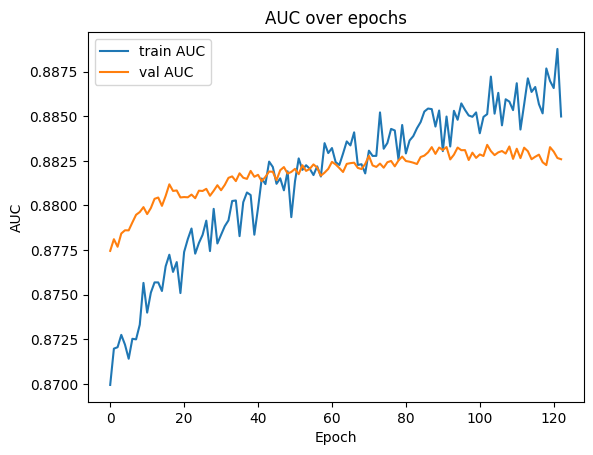

In [10]:

# === Plot learning curves ===
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history["auc"], label="train AUC")
plt.plot(history.history["val_auc"], label="val AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.title("AUC over epochs")
plt.show()


In [11]:

# === Evaluate on test ===
proba = model.predict(X_test_p).ravel()
y_pred = (proba >= 0.5).astype(int)
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, proba)
print(f"Test Accuracy: {acc:.4f} | Test AUC: {auc:.4f}")
print(classification_report(y_test, y_pred, digits=4))


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
Test Accuracy: 0.7868 | Test AUC: 0.8756
              precision    recall  f1-score   support

           0     0.8010    0.7589    0.7794       647
           1     0.7742    0.8143    0.7938       657

    accuracy                         0.7868      1304
   macro avg     0.7876    0.7866    0.7866      1304
weighted avg     0.7875    0.7868    0.7866      1304

